# Farm Appraisal Analysis

## Introduction and Problem Background

Farm appraisers are interested in understanding what gives a particular farm its value. Knowing what factors increase or decrease the value of a farm will be valuable to an appraiser in determining a fair price for both the seller and buyer. Given the right factors we would be able to make predictions for the price of a farm. Being able to do this would not only save time and money but also potential mistakes that a novice or even an experienced appraiser might make when determining a price. In particular there is an appraiser who believes that the effect of on price in the NW is different than in other areas. 

The data we have on hand is from Farm.txt which includes variables such as productivity of the land and the region this farm is in. The response or predictive value would be the acrePrice. With these data we would like to create a model that would allow us to make these predictions we previously discussed. Before we do that we should explore the data and see which model and techniques are necessary to get the right predictions.  

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import statsmodels.graphics.api as smg

import statsmodels.api as sm
import scipy.stats as sci 
import math
import statistics as stat

from statsmodels.graphics.factorplots import interaction_plot

import copy

In [2]:
#Read in data
farm = pd.read_csv("Farms3.txt", sep = ' ')

#Type to category
farm['NW'] = farm['NW'].astype('category')
farm['SC'] = farm['SC'].astype('category')
farm['SE'] = farm['SE'].astype('category')
farm['SW'] = farm['SW'].astype('category')
farm['WC'] = farm['WC'].astype('category')
farm['financing'] = farm['financing'].astype('category')

farm_regions = copy.deepcopy(farm)

#Turn regions into one col
farm_regions['region'] = "C"
for i, row in farm_regions.iterrows():
    #print(row)
    if row['WC'] == 'Yes': 
        farm_regions['region'][i] = "WC"
    elif row['NW'] == 'Yes':  
        farm_regions['region'][i] = "NW"
    elif row['SC'] == 'Yes':  
        farm_regions['region'][i] = "SC"
    elif row['SE'] == 'Yes':  
        farm_regions['region'][i] = "SE"
    elif row['SW'] == 'Yes':  
        farm_regions['region'][i] = "SW"
del farm_regions['SE']
del farm_regions['WC']
del farm_regions['NW']
del farm_regions['SC']
del farm_regions['SW']
farm_regions['region'] = farm_regions['region'].astype('category')
farm_regions['region'].cat.reorder_categories(['C', 'NW', 'SC', 'SE', 'SW', 'WC'], inplace=True)

C:\Users\jon\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jon\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jon\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jon\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

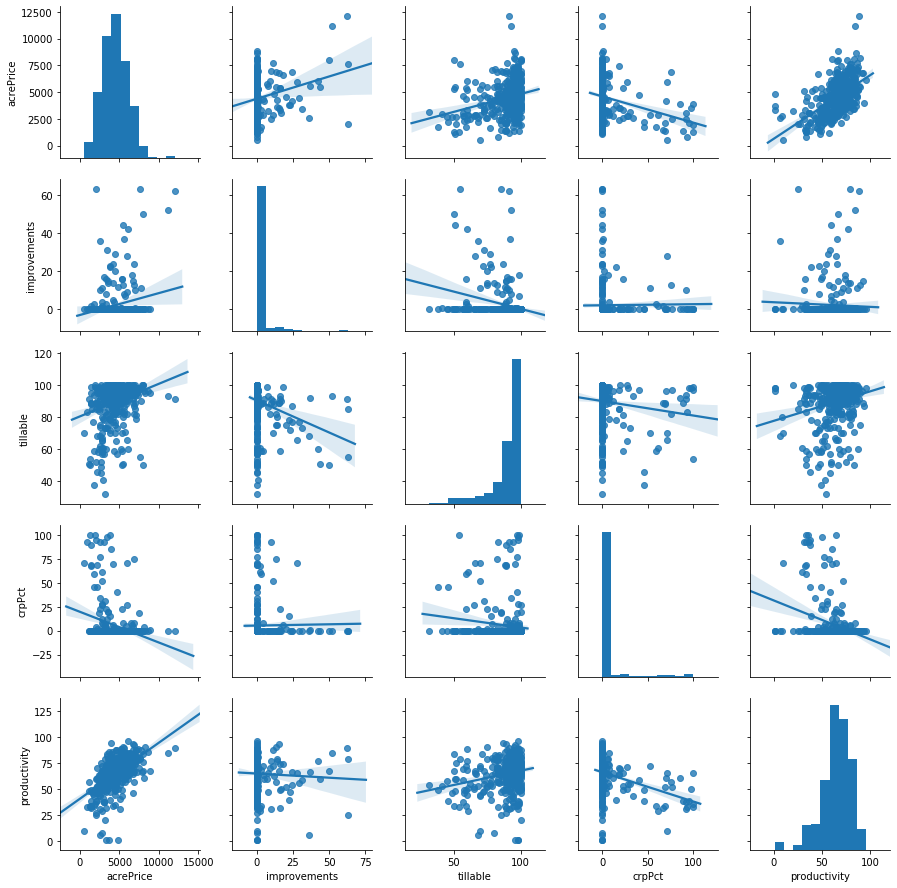

In [3]:
#Check for any needed transformations
sns.pairplot(farm, kind="reg")
#farm_log.describe()
#farm_log.info()

The scatter plot matrix above shows individual plots for each variable. The data for acrePrice had several outliers so I went ahead and transformed the data so that we make sure we follow the assumptions we are making for multiple linear regression. A noticeable correlation is between productivity and acrePrice where there is a somewhat strong positive correlation between them. There may also be a few variables that have collinearity which I can address shortly. The reason we concern ourselves with collinearity is that it can inflate our standard errors which could throw off our estimates as they would be highly sensitive to changes in our observations. Calculating variance inflation factors helps to see which variables are collinear or if there is even any collinearity at all. 

In [4]:
#farm_log.corr()
#Model
explan_vars = "+".join(farm.columns[1:10])
mlr = smf.ols('np.log(acrePrice)~'+explan_vars, data=farm).fit()

#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
exog = mlr.model.exog

VIF = pd.DataFrame()
VIF["features"] = farm.columns[1:10]
VIF["VIF Factor"] = [vif(exog, i) for i in range(1,10)]
#VIF

After looking at the variance inflation factors and correlations we can see that there does not seem to be any collinearity.

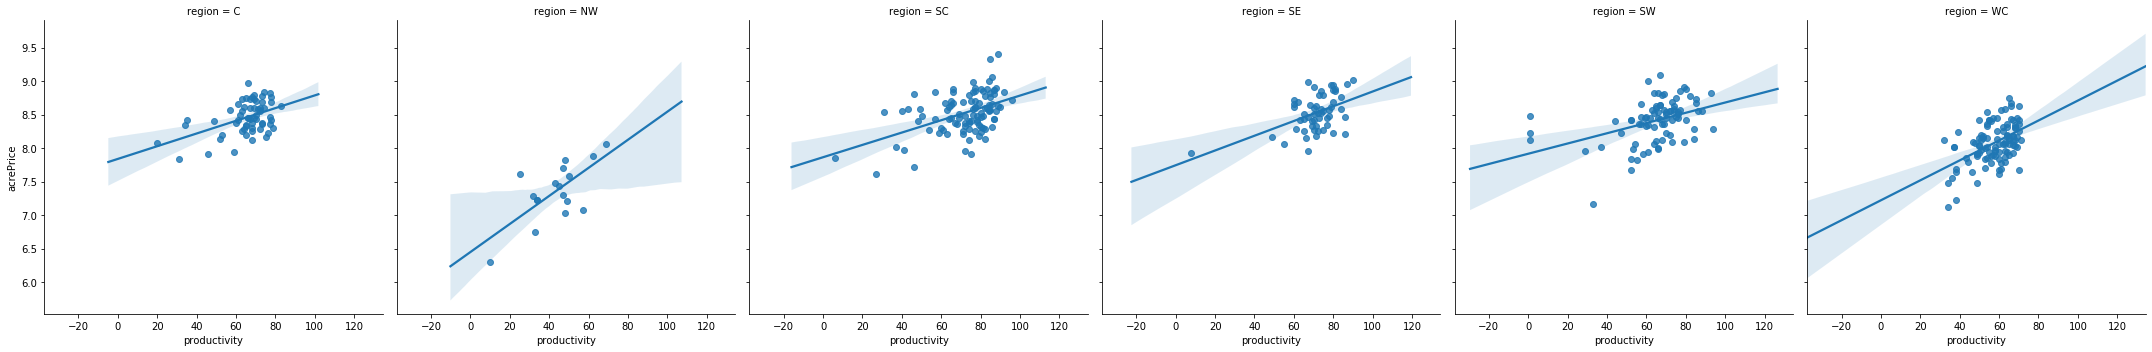

In [5]:
#Check for Interactions
farm_log_regions = copy.deepcopy(farm_regions)
farm_log_regions["acrePrice"] = np.log(farm_log_regions["acrePrice"])

myPlot = sns.lmplot(x='productivity', y='acrePrice', 
           col='region', data=farm_log_regions)

After making the proper transformation I went ahead and checked for any kind of interactions. The plots above show the different regions side by side with acrePrice and productivity as the axes. Upon plotting several different plots I found that regions had distinct clusters across each group and in particular the NW region. For the most part the clusters appear to be linear. Most of the regions have roughly the same slope or they have roughly the same increase in acrePrice for each unit increase of productivity. However, the NW region seems to increase more sharply (having a different slope than the rest) which would suggest an interaction between productivity and region.  

We looked at the data, explored trends within the data, made a transformation on our response to conform to the assumptions we are making when using a multiple linear regression model, and checked for collinearity as well as any kind of interactions. Now we are ready to start building a statistical model. 

## Statistical Modeling

In the case of farm appraisals there are several factors that may or may not have an impact on the price of land. Our main goal is to use the variables that are actually important in our model. We can use a variable selection technique that will take out certain variables in such a way we do not reduce our model too much while also optimizing our model. For this model I used best subset selection procedure which considers all possible combinations of variables. Since we had a reasonable amount of variables (not computationally intensive) this method seemed ideal. I also based my variable selection procedure on the AIC. I chose this procedure as it seems to optimize for making predictions. Prediction is what we would like to achieve in this analysis. See the code in the appendix for the process I went through to build this model. Below is the model I found using the variable selection technique. 

I also compared the reduced and full models to verify that adding an interaction term was important. After running an F-test for an interaction and got a p-value below a .05 and thus concluded that adding an interaction term was statistically significant. 

In [6]:
#Variable and Model Selection
from rpy2.robjects.packages import importr 
from rpy2.robjects import pandas2ri
pandas2ri.activate() # this activates an R session within python
base_r = importr('base')
bestglm = importr('bestglm')

farm_log = copy.deepcopy(farm)
farm_log["acrePrice"] = np.log(farm_log["acrePrice"])

ex_vars = list(farm_log.columns[1:10])
df = farm_log[ex_vars+['acrePrice']]

#Best subset selection
select = bestglm.bestglm(df, IC="AIC", method="exhaustive")

#see model
#print(base_r.summary(select.rx2('BestModel')))

#Model after variables were selected
mlm = smf.ols('np.log(acrePrice)~improvements+tillable+crpPct+productivity+NW+SC+SE+SW+productivity:NW', data=farm).fit()

**Simple Multiple Linear Regression Model:** $log(y_i) = \beta_0 + \beta_1(improvements) + \beta_2(tillable) + \beta_3(crpPct) + \beta_4(productivity) + \beta_5 I(region = NC) + \beta_6 I(region = SC) + \beta_7 I(region = SE) + \beta_8 I(region = SW) + \beta_9 I(region = NW) + \beta_{10} (productivity)x(I(region = NW))$

with interpretations:

$\epsilon_i \stackrel{iid}{\sim} N(0, \sigma^2)$ - What this means is that our model is dependent on following the assumptions: linear, independent, normal, and equal variance which we will test shortly. In or order to use the simple multiple linear regression model we must follow these assumptions. 

$\epsilon_i$ - The error associated with an observation's distance between a dot and the line. 

$log(y_i)$ - the response variable for the ith data point interpreted as the log of the acrePrice. 

$\beta_0$ - The intercept. On average this is what we would expect the acrePrice to be if the farm was located in the Central region (as the Central Region was our base factor) and all other variables were zero. 

(improvements) - This is a data point for improvements used to predict the acrePrice. Other variables like this can be interpreted this way as well. 

$\beta_1$ - The slope for the 1st explanatory variable improvements. Holding all else constant if improvements increases by 1 unit then acrePrice would increase by $\beta_1$ on average. Other slope coefficients can be interpreted in the same manner. 

Interactions - As productivity goes up by 1, then acrePrice goes up by $\beta_4$ for the central region, $\beta_4$ + $\beta_{5}$ for the NC region, $\beta_4$ + $\beta_{6}$ for the SC region, $\beta_4$ + $\beta_{7}$ for the SE region, $\beta_4$ + $\beta_{8}$ for the SW region, and $\beta_4$ + $\beta_{10}$ for the NW region.

$\sigma^2$ - The variance about the line or how far our distances are from the average. Or how much life expectancy varies from the average given the explanatory variables.  

After fitting our model to the data we should be able to predict the an acrePrice for a farm given our variables and region group. 

In [7]:
full_lm = smf.ols(formula="np.log(acrePrice)~improvements+tillable+crpPct+productivity+NW+SC+SE+SW+productivity:NW", data=farm).fit()
reduced_lm = smf.ols(formula="np.log(acrePrice)~improvements+tillable+crpPct+productivity+NW+SC+SE+SW", data=farm).fit()
full_lm.params

from statsmodels.stats.anova import anova_lm

anova_lm(reduced_lm,full_lm) #This checks if the full model is better or not

C:\Users\jon\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\jon\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\jon\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,411.0,25.196870,0.0,NaN,NaN,NaN
1,410.0,24.945825,1.0,0.251044,4.126067,0.042872


## Model Justification and Verification

Now we will test the fit of our model to determine how well is fits our data as well as check the assumptions we made previously about using a regression model. 

### Assumptions

As noted earlier in order to use this model we must follow four assumptions. These four assumptions are listed below. 

### Equal Variance and independence

The Scatterplot of Standardized Residuals below shows that the residuals are mostly evenly spread out. Just to be sure there is equal variance I ran a Breusch-Pagan test. The test returned p-values that were all high enough to conclude that these data are have equal variance and do not violate homoscedasticity so this assumption was met.  

As far as independence knowing about one data point may in fact have an affect another. Perhaps knowledge of someone being more productive in the same region might influence another's productivity score. I am going to go ahead and assume independence however.  

(4.176393096199158, 0.12391040088099098, -0.08502007400829838, 2.5420290597308415)


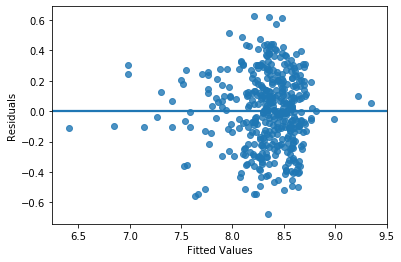

In [67]:
sns.regplot(x=mlm.fittedvalues, y=mlm.resid, data=farm_log, ci=None)
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
print(sms.jarque_bera(mlm.resid))

### Normality 

The histogram below appears normal but just to be sure I ran a Kolmogorov-Smirnov test for normality of
residuals which says we cannot reject the null hypothesis that the data do come from a normal so we can conclude that the data are normal given a p-value of 0.8783. 

KstestResult(statistic=0.028746624285611033, pvalue=0.8783395558733151)


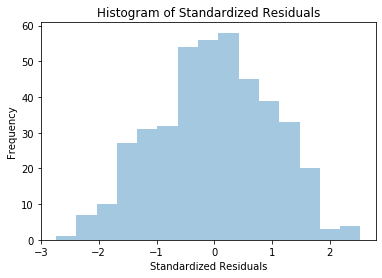

In [68]:
sns.distplot(mlm.resid_pearson, kde = False) #Does not include the density line
plt.ylabel("Frequency")
plt.xlabel("Standardized Residuals")
plt.title("Histogram of Standardized Residuals")
print(sci.kstest(mlm.resid_pearson, 'norm'))

### Linearity

For linearity we will use a partial regression plot which looks at each variable individually. We could also use the scatter plots we plotted earlier in the paper as a guide as well. The plots below show that the data are linear on the individual basis that is isolating each of the variables we see that they follow a linear trend. Hence we are fine to go ahead with using our model. 

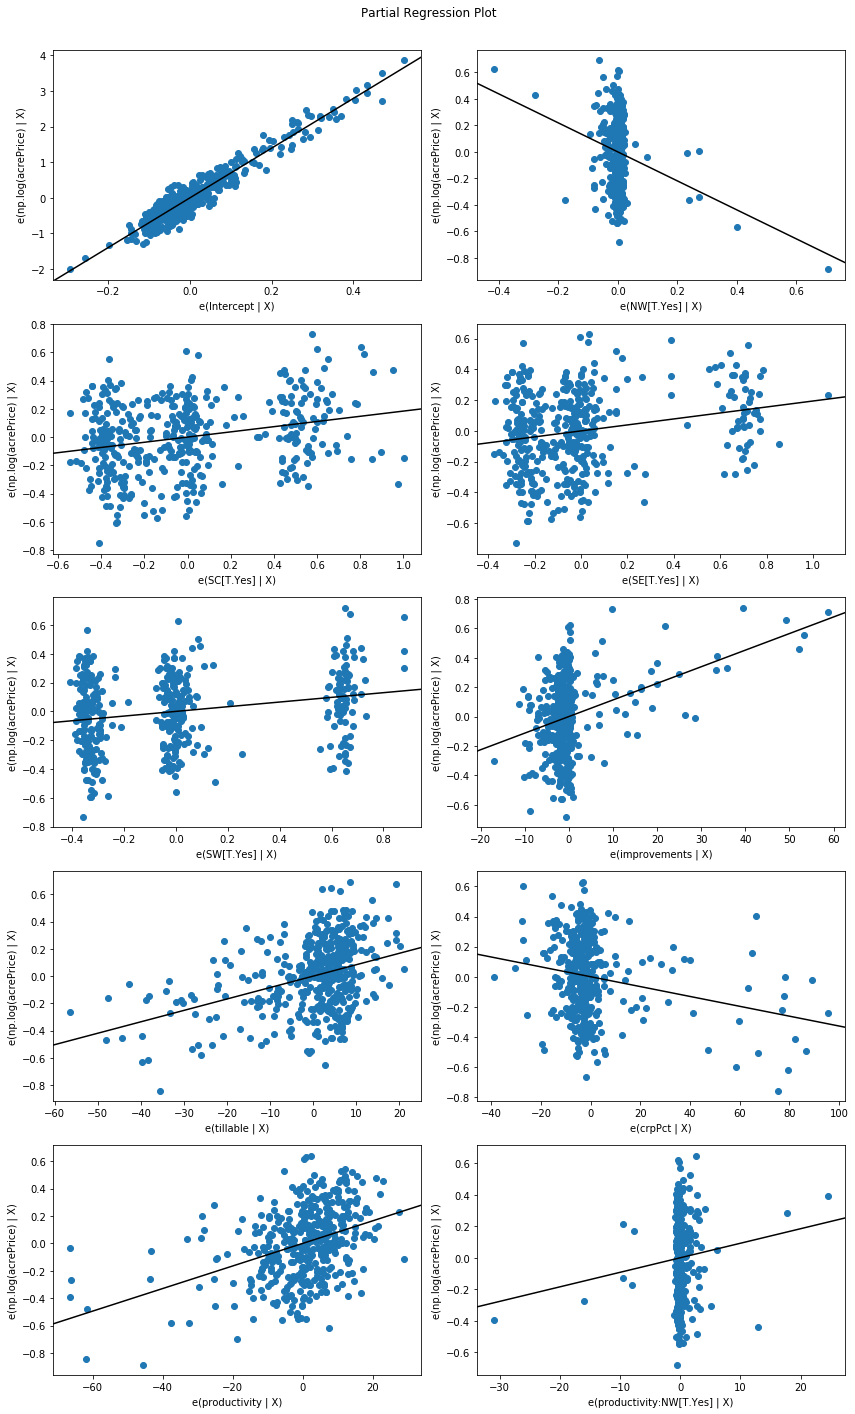

In [66]:
fig = plt.figure(figsize=(12,20))
fig = sm.graphics.plot_partregress_grid(mlm, fig=fig)

### Model Prediction Ability

After running some numbers we see that our $R^2$ is **0.6335**. What this says is that about 63% of the variation in acrePrice is explained by all variables, main effects and interaction combined. This number is not too bad. Our bias says we are under-predicting by (**-133.41**) unit price. This number is some what small which says our model is slightly biased. RPMSE of about **1105.5026** says that our predictions about acrePrice given all of the explanatory variables combined are off by 1105.5026 unit price. This number is a little large meaning that our predictions will be off when we make predictions about acrePrice. The coverage tells us the percentage of predication intervals that contain the true value we are looking for. For our model about **96%** of the true values we are looking for are are contained with in predication intervals. Lastly, prediction interval width is just the average width of our prediction or the difference between the upper and lower bounds of our prediction intervals. In our model the average width is roughly **4429.76** price units. This width covers roughly mean of the acrePrice or zero standard deviations. The downside to such a narrow width is that our predictions will be off. 

In [9]:
#Cross Validation

ncv = 250 
bias = np.repeat(np.NaN, ncv) 
rpmse = np.repeat(np.NaN, ncv)
coverage = np.repeat(np.NaN, ncv)
pred_interval_width = np.repeat(np.NaN, ncv)
ntest = 10 
n = 420
for cv in range(ncv):
    # Choose which obs. to put in test set
    testObs = np.random.choice(n, ntest)
    
    # Split data into test and training sets
    testSet = farm.iloc[testObs,:]
    trainSet = farm.drop(testObs)
  
    trainlm = smf.ols(formula='np.log(acrePrice)~improvements+tillable+crpPct+productivity+NW+SC+SE+SW+productivity:NW', 
                      data=trainSet).fit()
    
    # Predict test set
    testPreds = trainlm.get_prediction(testSet)
    
    #Untransform 
    cis = np.exp(testPreds.conf_int(obs=True))
    testPreds.predicted_mean = np.exp(testPreds.predicted_mean)
    
    # Calculate bias
    bias[cv] = np.mean(testPreds.predicted_mean-testSet['acrePrice'])
    
    # Calculate RPMSE
    rpmse[cv] = math.sqrt(np.mean((testPreds.predicted_mean-testSet['acrePrice']) ** 2))
    
    # Calc coverage 
    cond_met = np.logical_and(cis[:,0]<=testSet['acrePrice'].values, cis[:,1]>=testSet['acrePrice'].values)
    coverage[cv] = np.mean(cond_met)
    
    #Prediction interval width
    pred_interval_width[cv] = np.mean(cis[:,1]-cis[:,0])
    
# R^2
print("R^2 = {}".format(mlm.rsquared))

#Bias 
print("Bias: {}".format(np.mean(bias)))

#RPMSE 
print("RPMSE: {}".format(np.mean(rpmse)))

#Coverage 
print("Coverage: {}".format(np.mean(coverage)))

#Prediction interval width 
print("Prediction interval width: {}".format(np.mean(pred_interval_width)))

#Conf Interval
#mlr.conf_int(alpha=.05)

R^2 = 0.633544839892098
Bias: -105.70907852993999
RPMSE: 1076.9852933012007
Coverage: 0.9588000000000001
Prediction interval width: 4424.906138629018


## Results

We use F-tests to determine if there are real affects on our response variable (acrePrice). Our first F-tests we determine if each covariate and interaction in our model have any real affect on acrePrice. 

Below is a table of with the covariate or interaction predictors to the left, each of their 95% confidence intervals, and a p-val after conducting an F-test. 

| Covariate | [.025] | [.0975] | p-val
| --- | --- | --- | --- |
| Intercept | 6.770	 | 7.169 | 0 | 
| NW | -1.507 | -0.681 | 0 |
| SC | 0.119 | 0.249 | 0 |
| SE | 0.116 | 0.273 | 0 |
| SW | 0.097 | 0.228 | 0 |
| improvements | 0.008 | 0.014 | 0 |
| tillable | 0.006 | 0.010 | 0 |
| crpPct | -0.005 | -0.002 | 0 |
| productivity | 0.006 | 0.010 | 0 |
| productivity:NW[T.Yes] | 0 | 0.018 | .043 |

Assuming an $\alpha$ of .05, the p-values in the table are well below $\alpha$. This would indicate that these predictors have a significant affect on acrePrice. For both the region NW and the interaction of productivity and the region NW we can say that they do have an effect on acrePrice since their p-value is well below .05. We had also checked previously that the interaction was significant enough to include in our model. We can interpret the NW region categorical variable as holding all else constant we are 95% confident that acrePrice will have an increase in price between exp(-1.507) and exp(-0.681) (or .2216 and .5061 untransformed) for farms in the NW region. We can interpret the variable productivity as holding all else constant we are 95% confident that acrePrice will have an increase in price between exp(0.006) and exp(0.010) (or 1.006 and 1.01 untransformed) for farms that increase in productivity by one unit. As for interpreting the interaction term, holding all else constant we are 95% confident that farms in the NW region have between 1 and 1.0182. 

The claim that the appraiser makes could hold. I ran predictions for multiple regions holding all else constant and the NW region is worth a little less than the others on average. However, since we have such a wide prediction interval we get values for NW that overlap other region prices. 

### Making Predictions

We can make predictions for acrePrice by simply plugging in the parameters (i.e. productivity) into our model and run the calculation. Below is our example in question.

If we make a prediction for the data that was given in question we would expect to see a an acrePrice being exp(8.341167) or  4192.98 on average with an interval of (2122.60, 8282.799). Our prediction is around the mean for acrePrice and our prediction interval is really wide. Having such a wide interval leaves room for a lot of variance in our acrePrices.   

In [11]:
#pepper+easiness+raterInterest+disciplineSTEM+deptBusiness+deptPhysics

dframe = pd.DataFrame(dict(improvements=[0],tillable=[94], crpPct=[0], productivity=[96], 
                    NW=['Yes'], SC=['No'], SE=['No'], SW=['No']))

print("Prediction: {}".format(mlm.predict(dframe)))

preds = mlm.get_prediction(pd.DataFrame(dict(improvements=[0],tillable=[94], crpPct=[0], productivity=[96], 
                    NW=['Yes'], SC=['No'], SE=['No'], SW=['No'])))

#Calculate a 95% prediction interval 
print("Predication: {}".format(preds.conf_int(obs=True, alpha = .05))) 

Prediction: 0    8.341167
dtype: float64
Predication: [[7.66039851 9.02193627]]


## Conclusions

Overall our model predicts pretty well where on average we will predict the right acrePrice. The downside to our model is that we have such a wide prediction interval which means we may be getting a wide variety for acrePrice. There does seem to be a different affect with farms in the NW region and productivity also seems to have an influence on the NW region. How much of a difference is hard to tell with this model. 

To better understand and predict acre price an appraiser could learn more about the NW region. It may be helpful to know more about what makes it different. The appraiser might be surprised that there is not much difference between regions and productivity.  